# Makine Öğrenmesi ile Yetenek Avcılığı Sınıflandırma


# İş Problemi:

Scoutlar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf (average, highlighted) oyuncu olduğunu tahminleme.


# Veriseti Hikayesi:

Veri seti Scoutium’dan maçlarda gözlemlenen futbolcuların özelliklerine göre scoutların değerlendirdikleri futbolcuların, maç içerisinde puanlanan özellikleri ve puanlarını içeren bilgilerden oluşmaktadır.

attributes: Oyuncuları değerlendiren kullanıcıların bir maçta izleyip değerlendirdikleri her oyuncunun özelliklerine verdikleri puanları içeriyor. (bağımsız değişkenler)

potential_labels: Oyuncuları değerlendiren kullanıcıların her bir maçta oyuncularla ilgili nihai görüşlerini içeren potansiyel etiketlerini içeriyor. (hedef değişken)

9 Değişken, 10730 Gözlem, 0.65 mb

# Değişkenler:
!pip install lightgbm

task_response_id: Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi.

match_id: İlgili maçın id'si.

evaluator_id: Değerlendiricinin(scout'un) id'si.

player_id: İlgili oyuncunun id'si.

position_id: İlgili oyuncunun o maçta oynadığı pozisyonun id'si.
1- Kaleci
2- Stoper
3- Sağ bek
4- Sol bek
5- Defansif orta saha
6- Merkez orta saha
7- Sağ kanat
8- Sol kanat
9- Ofansif orta saha
10- Forvet

analysis_id: Bir scoutun bir maçta bir oyuncuya dair özellik değerlendirmelerini içeren küme.

attribute_id: Oyuncuların değerlendirildiği her bir özelliğin id'si.

attribute_value: Bir scoutun bir oyuncunun bir özelliğine verilen değer(puan).

potential_label: Bir scoutun bir maçta bir oyuncuyla ilgili nihai kararını belirten etiket. (hedef değişken)

In [1]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_predict
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
df = pd.read_csv("makine öğrenmesi projeleri/Scoutium/scoutium_attributes.csv", sep=";")
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [8]:
df.shape

(10730, 8)

In [9]:
df2 = pd.read_csv("makine öğrenmesi projeleri/Scoutium/scoutium_potential_labels.csv", sep=";")
df2.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [10]:
df2.shape

(322, 5)

Okutmuş olduğum csv dosyalarını merge fonksiyonunu kullanarak birleştirdim.  
("task_response_id", 'match_id', 'evaluator_id' "player_id"  4 adet değişken üzerinden birleştirme işlemini gerçekleştirdim.)

In [12]:
dff = pd.merge(df, df2, how='left', on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])
dff.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


position_id içerisindeki Kaleci (1) sınıfını verisetinden kaldırdım.

In [13]:
dff = dff[dff["position_id"] != 1]

potential_label içerisindeki below_average sınıfını verisetinden kaldırdım.
( below_average sınıfı  tüm verisetinin %1'ini oluşturur)

In [14]:
dff = dff[dff["potential_label"] != "below_average"]

Oluşturduğum veri setinden “pivot_table” fonksiyonunu kullanarak bir tablo oluşturdum. 

Bu pivot table'da her satırda bir oyuncu olacak şekilde manipülasyon yaptım.

İndekste “player_id”,“position_id” ve “potential_label”,  sütunlarda “attribute_id” ve değerlerde scout’ların oyunculara verdiği puan “attribute_value” olacak şekilde pivot table’ı oluşturdum


In [27]:
pt = pd.pivot_table(dff, values="attribute_value", columns="attribute_id", index=["player_id","position_id","potential_label"])

“reset_index” fonksiyonunu kullanarak index hatasından kurtuldum ve “attribute_id” sütunlarının isimlerini stringe çevirdim.

In [28]:
pt = pt.reset_index(drop=False)

pt.columns = pt.columns.map(str)

pt.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


Label Encoder fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade ettim.

In [18]:
le = LabelEncoder()
pt["potential_label"] = le.fit_transform(pt["potential_label"])

Sayısal değişken kolonlarını “num_cols” adıyla bir listeye atadım

In [30]:
num_cols = pt.columns[3:]

num_cols

Index(['4322', '4323', '4324', '4325', '4326', '4327', '4328', '4329', '4330',
       '4332', '4333', '4335', '4338', '4339', '4340', '4341', '4342', '4343',
       '4344', '4345', '4348', '4349', '4350', '4351', '4352', '4353', '4354',
       '4355', '4356', '4357', '4407', '4408', '4423', '4426'],
      dtype='object', name='attribute_id')

Kaydettim bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için standardScaler uyguladım.

In [21]:
scaler = StandardScaler()
pt[num_cols] = scaler.fit_transform(pt[num_cols])


Elimdeki veri seti üzerinden minimum hata ile futbolcuların potansiyel etiketlerini tahmin eden bir makine öğrenmesi modeli geliştirdim.

In [22]:
y = pt["potential_label"]
X = pt.drop(["potential_label", "player_id"], axis=1)

models = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('CatBoost', CatBoostClassifier(verbose=False)),
              ("LightGBM", LGBMClassifier())]


In [23]:
for name, model in models:
    print(name)
    for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
        cvs = cross_val_score(model, X, y, scoring=score, cv=10).mean()
        print(score+" score:"+str(cvs))

LR
roc_auc score:0.8452886002886002
f1 score:0.5684648684648684
precision score:0.7738095238095238
recall score:0.49000000000000005
accuracy score:0.8525132275132276
KNN
roc_auc score:0.7256998556998557
f1 score:0.4278571428571428


C:\Users\buket\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision score:0.775
recall score:0.30999999999999994
accuracy score:0.8449735449735449
SVC
roc_auc score:0.8439105339105339
f1 score:0.03333333333333334
precision score:0.1


C:\Users\buket\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\buket\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\buket\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\buket\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision 

recall score:0.02
accuracy score:0.797089947089947
CART
roc_auc score:0.7225974025974027
f1 score:0.5347730047730048
precision score:0.5542857142857143
recall score:0.5566666666666666
accuracy score:0.7896825396825398
RF
roc_auc score:0.9053391053391053
f1 score:0.5845238095238094
precision score:0.925
recall score:0.4533333333333333
accuracy score:0.8707671957671957
Adaboost
roc_auc score:0.8647474747474746
f1 score:0.5999062049062049
precision score:0.7771428571428571
recall score:0.5433333333333333
accuracy score:0.8560846560846562
GBM
roc_auc score:0.8719336219336219
f1 score:0.5672799422799423
precision score:0.8016666666666667
recall score:0.5033333333333334
accuracy score:0.8671957671957673
XGBoost
roc_auc score:0.8558080808080808
f1 score:0.611030081030081
precision score:0.7397619047619048
recall score:0.5766666666666665
accuracy score:0.8563492063492063
CatBoost
roc_auc score:0.9040981240981241
f1 score:0.5937662337662338
precision score:0.93
recall score:0.47000000000000003


 Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdirdim.

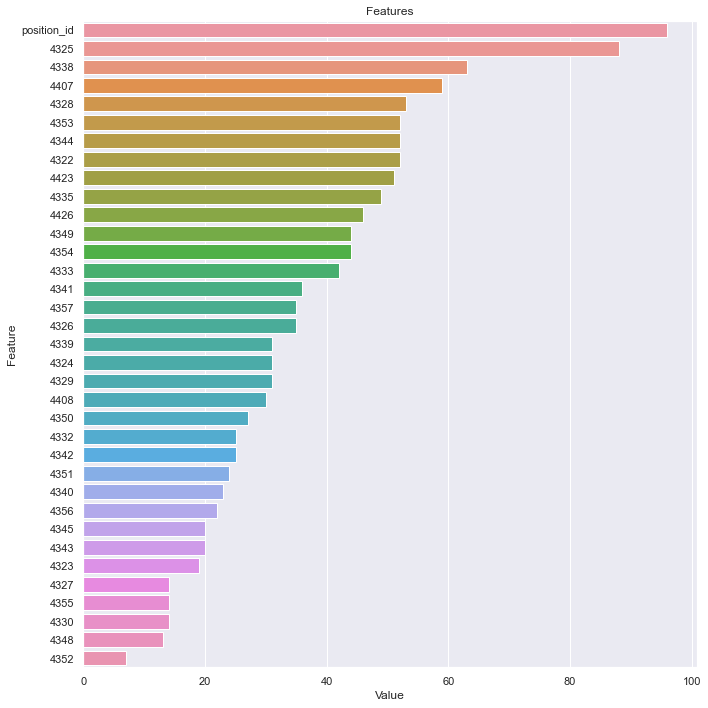

In [24]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = LGBMClassifier()
model.fit(X, y)

plot_importance(model, X)
